# Accessing the project directory on my Google Drive  

In [1]:
import os
from google.colab import drive

drive.mount('/drive', force_remount=False)
project_dir = "/drive/My Drive/RNNSeq2Seq/"

# change working directory to project_dir
os.chdir(project_dir)

Mounted at /drive


# Dependencies

In [2]:
from scripts.model import *
from scripts.dataloader import create_dataloader
from scripts.utils import *
from scripts.pytorch_utils import *
import matplotlib.pyplot as plt

# Helper function to help visualize 

In [3]:
def plot_log(log):
    len_range = len(log) -1 if "Best eval accu" in log else len(log)
    epoch_nums, train_loss, dev_loss = [], [], []
    train_acc, dev_acc = [], []

    for epoch in range(1, len_range+1):
        epoch_nums.append(epoch)
        train = log[f"Epoch#{epoch}"]["Train"]
        dev = log[f"Epoch#{epoch}"]["Eval"]
        train_loss.append(train['loss'])
        train_acc.append(train['abosulate accuracy'])

        dev_loss.append(dev['loss'])
        dev_acc.append(dev['abosulate accuracy'])

    ax1 = plt.subplot(211)
    ax1.plot(epoch_nums, train_loss, label="train loss")
    ax1.plot(epoch_nums, dev_loss, label="dev loss")
    ax1.legend()

    ax2 = plt.subplot(212)
    ax2.plot(epoch_nums, train_acc, label="train acc")
    ax2.plot(epoch_nums, dev_acc, label="dev acc")
    ax2.legend()
    plt.show()

In [4]:
folder = "tuning_data/"
experiment_num = 1
shuffle_batch = False

# must be the num of seq per seq length if shuffle_batch is False
# this "tr_batch_size" will be used for dev, and shuffled test sets
tr_batch_size = 250 
dev_batch_size = 500 if not shuffle_batch else tr_batch_size

In [5]:
# setups for training and evaluting

print_freq = 5
acc_threshold = 0.9 # for saving the best trained models 
max_epoch_num = 100 # max num of epoches 
train_acc_exit=0.9999 # train acc exit threshold (eval_acc_exit must also be met)
eval_acc_exit=0.995 # dev acc exit threshold (train_acc_exit must also be met)
teacher_forcing_ratio = 1.0 # probability of using real symbol from target sequence for training

# RevStr

In [5]:
train = read_data(join(folder, "RevStr/train.txt"))
dev = read_data(join(folder, "RevStr/dev.txt"))
saved_model_fp = join(project_dir, "notebooks/Hyperparatemers Tuning/RevStr_model.pt")

train_dl = create_dataloader(train, batch_size=tr_batch_size, shuffle=shuffle_batch)
dev_dl = create_dataloader(dev, batch_size=dev_batch_size, shuffle=shuffle_batch)

## Hyperparameter set 1

- hidden_size = 64
- embd_dim = 32
- learning_rate = 5e-3

In [9]:
in_vocab = ascii_lowercase
out_vocab = ascii_lowercase
in_vocab_size = len(in_vocab) + 2
out_vocab_size = len(out_vocab) + 2

hidden_size = 64
embd_dim = 32
num_layers = 1
rnn_type = "GRU"
dropout_rate = 0.0
bidirectional = True
use_attention = True
reduction_method = torch.sum

learning_rate = 5e-3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

encoder = Encoder(in_vocab_size, hidden_size, 
                  embd_dim, num_layers, rnn_type, 
                  dropout_rate, bidirectional, 
                  reduction_method)
attention = Attention(hidden_size)
decoder = Decoder(out_vocab_size, hidden_size, 
                  embd_dim, num_layers, rnn_type,
                  attention, use_attention, 
                  dropout_rate)

model = Seq2Seq(encoder, decoder, device).to(device)
model.apply(init_weights)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [10]:
log = train_and_evaluate(model, train_dl, dev_dl, criterion, optimizer, 
                         saved_model_fp, acc_threshold, print_freq, max_epoch_num, 
                         train_acc_exit, eval_acc_exit, teacher_forcing_ratio)

Current epoch: 5, 
training performance: {'loss': 1.8103975802659988, 'abosulate accuracy': 0.0006000000284984708, 'consecutive overlap rate': 0.17954614302143454, 'overlap rate': 0.4967197962105274}
evaluation performance: {'loss': 2.3566857278347015, 'abosulate accuracy': 0.0003000000084284693, 'consecutive overlap rate': 0.1760274101048708, 'overlap rate': 0.3225739743560553}

Current epoch: 10, 
training performance: {'loss': 0.06571003263816237, 'abosulate accuracy': 0.716000036150217, 'consecutive overlap rate': 0.8991684958338737, 'overlap rate': 0.9926213949918747}
evaluation performance: {'loss': 0.4833937951363623, 'abosulate accuracy': 0.7156000338494778, 'consecutive overlap rate': 0.8831576183438301, 'overlap rate': 0.9247920006513596}

Current epoch: 15, 
training performance: {'loss': 0.011824858956970274, 'abosulate accuracy': 0.9029000371694564, 'consecutive overlap rate': 0.9867330640554428, 'overlap rate': 0.9992986917495728}
evaluation performance: {'loss': 0.052413

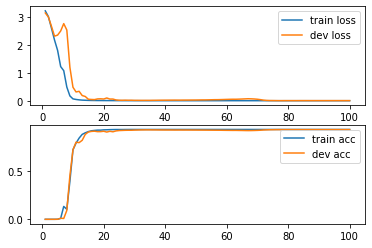

In [11]:
plot_log(log)

## Hyperparameter set 2

- hidden_size = 256
- embd_dim = 128
- learning_rate = 5e-4

In [44]:
hidden_size = 256
embd_dim = 128
num_layers = 1
rnn_type = "GRU"
encoder = Encoder(in_vocab_size, hidden_size, 
                  embd_dim, num_layers, rnn_type, 
                  dropout_rate, bidirectional, 
                  reduction_method)
attention = Attention(hidden_size)
decoder = Decoder(out_vocab_size, hidden_size, 
                  embd_dim, num_layers, rnn_type,
                  attention, use_attention, 
                  dropout_rate)

model = Seq2Seq(encoder, decoder, device).to(device)
model.apply(init_weights)

learning_rate = 5e-4
# criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [45]:
log = train_and_evaluate(model, train_dl, dev_dl, criterion, optimizer, 
                         saved_model_fp, acc_threshold, print_freq, max_epoch_num, 
                         train_acc_exit, eval_acc_exit, teacher_forcing_ratio)

Current epoch: 5, 
training performance: {'loss': 1.8578591406345368, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.03752814033068717, 'overlap rate': 0.41256032809615134}
evaluation performance: {'loss': 2.164602020382881, 'abosulate accuracy': 0.00010000000474974513, 'consecutive overlap rate': 0.09672315437346697, 'overlap rate': 0.3027180142700672}

Current epoch: 10, 
training performance: {'loss': 1.0405377343297004, 'abosulate accuracy': 0.012400000635534526, 'consecutive overlap rate': 0.26759012788534164, 'overlap rate': 0.7204490020871163}
evaluation performance: {'loss': 1.8766873687505723, 'abosulate accuracy': 0.03895000157644972, 'consecutive overlap rate': 0.28676915541291237, 'overlap rate': 0.5013757050037384}

Current epoch: 15, 
training performance: {'loss': 0.48246212378144265, 'abosulate accuracy': 0.13480000550625845, 'consecutive overlap rate': 0.45981761422008277, 'overlap rate': 0.8854318886995316}
evaluation performance: {'loss': 1.3349883891642094

# RedStr



In [11]:
train = read_data(join(folder, "RedStr/train.txt"))
dev = read_data(join(folder, "RedStr/dev.txt"))
saved_model_fp = join(project_dir, "notebooks/Hyperparatemers Tuning/RevStr_model.pt")

train_dl = create_dataloader(train, batch_size=tr_batch_size, shuffle=shuffle_batch)
dev_dl = create_dataloader(dev, batch_size=dev_batch_size, shuffle=shuffle_batch)

## Hyperparameter set 1

- hidden_size = 64
- embd_dim = 32
- learning_rate = 5e-3

In [16]:
in_vocab = ascii_lowercase
out_vocab = ascii_lowercase
in_vocab_size = len(in_vocab) + 2
out_vocab_size = len(out_vocab) + 2

hidden_size = 64
embd_dim = 32
num_layers = 1
rnn_type = "GRU"
dropout_rate = 0.0
bidirectional = True
use_attention = True
reduction_method = torch.sum

learning_rate = 5e-3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

encoder = Encoder(in_vocab_size, hidden_size, 
                  embd_dim, num_layers, rnn_type, 
                  dropout_rate, bidirectional, 
                  reduction_method)
attention = Attention(hidden_size)
decoder = Decoder(out_vocab_size, hidden_size, 
                  embd_dim, num_layers, rnn_type,
                  attention, use_attention, 
                  dropout_rate)

model = Seq2Seq(encoder, decoder, device).to(device)
model.apply(init_weights)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [17]:
log = train_and_evaluate(model, train_dl, dev_dl, criterion, optimizer, 
                         saved_model_fp, acc_threshold, print_freq, max_epoch_num, 
                         train_acc_exit, eval_acc_exit, teacher_forcing_ratio)

Current epoch: 5, 
training performance: {'loss': 2.303030440211296, 'abosulate accuracy': 0.0036000001593492923, 'consecutive overlap rate': 0.17006596075370908, 'overlap rate': 0.44242690652608874}
evaluation performance: {'loss': 2.8826505124568937, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.0779773073270917, 'overlap rate': 0.17604540176689626}

Current epoch: 10, 
training performance: {'loss': 0.8673074923455715, 'abosulate accuracy': 0.013200000638607889, 'consecutive overlap rate': 0.24084016177803277, 'overlap rate': 0.7771425448358059}
evaluation performance: {'loss': 3.1981522023677824, 'abosulate accuracy': 0.00740000035148114, 'consecutive overlap rate': 0.2925568874925375, 'overlap rate': 0.3990311428904533}

Current epoch: 15, 
training performance: {'loss': 0.09932678807526826, 'abosulate accuracy': 0.5845000240951777, 'consecutive overlap rate': 0.8080853939056396, 'overlap rate': 0.984722800552845}
evaluation performance: {'loss': 0.5159682705998421, 'ab

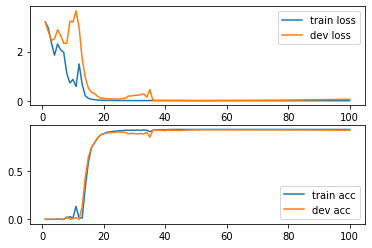

In [18]:
plot_log(log)

## Hyperparameter set 2

- hidden_size = 256
- embd_dim = 128
- learning_rate = 5e-4

In [19]:
in_vocab = ascii_lowercase
out_vocab = ascii_lowercase
in_vocab_size = len(in_vocab) + 2
out_vocab_size = len(out_vocab) + 2

hidden_size = 256
embd_dim = 128
num_layers = 1
rnn_type = "GRU"
dropout_rate = 0.0
bidirectional = True
use_attention = True
reduction_method = torch.sum

learning_rate = 5e-4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

encoder = Encoder(in_vocab_size, hidden_size, 
                  embd_dim, num_layers, rnn_type, 
                  dropout_rate, bidirectional, 
                  reduction_method)
attention = Attention(hidden_size)
decoder = Decoder(out_vocab_size, hidden_size, 
                  embd_dim, num_layers, rnn_type,
                  attention, use_attention, 
                  dropout_rate)

model = Seq2Seq(encoder, decoder, device).to(device)
model.apply(init_weights)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [20]:
log = train_and_evaluate(model, train_dl, dev_dl, criterion, optimizer, 
                         saved_model_fp, acc_threshold, print_freq, max_epoch_num, 
                         train_acc_exit, eval_acc_exit, teacher_forcing_ratio)

Current epoch: 5, 
training performance: {'loss': 2.1390719383955004, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.02480655724648386, 'overlap rate': 0.3316446840763092}
evaluation performance: {'loss': 2.4233616650104524, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.04187563904561102, 'overlap rate': 0.23547320179641246}

Current epoch: 10, 
training performance: {'loss': 1.1290839284658432, 'abosulate accuracy': 0.0019000000786036253, 'consecutive overlap rate': 0.22199648432433605, 'overlap rate': 0.6492565028369427}
evaluation performance: {'loss': 2.122917798161507, 'abosulate accuracy': 0.018550000176765023, 'consecutive overlap rate': 0.2919781282544136, 'overlap rate': 0.43337868303060534}

Current epoch: 15, 
training performance: {'loss': 0.4324691750109196, 'abosulate accuracy': 0.0850000044098124, 'consecutive overlap rate': 0.4206233685836196, 'overlap rate': 0.8813654810190201}
evaluation performance: {'loss': 1.121326431632042, 'abosulate accuracy

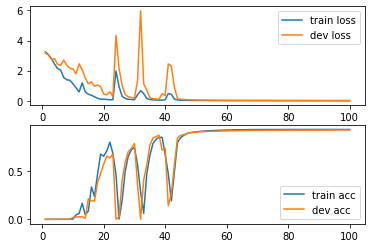

In [21]:
plot_log(log)